In [30]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, box, Polygon
import folium
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
import time
from pathlib import Path
import numpy as np
import math
import seaborn as sns

In [31]:
stops_full = pd.read_csv("/home/sanzio/Documents/geo/PublicTransportEmissions_Trento/google_transit_urbano_tte/stops.txt")
routes_full = pd.read_csv("/home/sanzio/Documents/geo/PublicTransportEmissions_Trento/google_transit_urbano_tte/routes.txt")
trips_full = pd.read_csv("/home/sanzio/Documents/geo/PublicTransportEmissions_Trento/google_transit_urbano_tte/trips.txt")
shapes_full = pd.read_csv("/home/sanzio/Documents/geo/PublicTransportEmissions_Trento/google_transit_urbano_tte/shapes.txt")
stop_times_full = pd.read_csv("/home/sanzio/Documents/geo/PublicTransportEmissions_Trento/google_transit_urbano_tte/stop_times.txt")


In [63]:
#We remove the routes that are outside the municipality of Trento
routes_to_remove = [
    578, 580, 582, 590, 592, 594, 598, 601, 602, 605, 
    607, 610, 612, 613, 512, 562, 563, 566, 531 #We are also removing the "Funivia", as it is not a bus transport
]

routes = routes_full[~routes_full['route_id'].isin(routes_to_remove)]

# Then filter GTFS tables
trips = trips_full[trips_full['route_id'].isin(routes['route_id'])]
stop_times = stop_times_full[stop_times_full['trip_id'].isin(trips['trip_id'])]
shapes = shapes_full[shapes_full['shape_id'].isin(trips['shape_id'])]
stops = stops_full[stops_full['stop_id'].isin(stop_times['stop_id'])]


In [64]:
# Get a mapping from route_id to shape_ids
route_shape_df = trips[['route_id', 'shape_id']].drop_duplicates()

# Merge shapes with route info and sort
shapes_merged = shapes.merge(route_shape_df, on='shape_id')
shapes_merged = shapes_merged.sort_values(by=['route_id', 'shape_id', 'shape_pt_sequence'])


In [65]:
def save_as_img(m, name):
    '''
    Function used to save folium maps as images using Selenium webdriver
    Html intermediate files are saved to a \html directory, while images are saved to a \images directory
    '''
    # Create directories if they don't exist
    html_dir = Path("html")
    img_dir = Path("images")
    html_dir.mkdir(exist_ok=True)
    img_dir.mkdir(exist_ok=True)

    html_path = html_dir / f"{name}.html"
    m.save(html_path)

    options = Options()
    options.add_argument("--headless")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")

    driver = webdriver.Chrome(options=options)
    driver.set_window_size(1200, 800)

    map_path = html_path.resolve().as_uri()
    driver.get(map_path)

    time.sleep(3)

    img_path = img_dir / f"{name}.png"
    driver.save_screenshot(str(img_path))
    driver.quit()

In [66]:
m = folium.Map(location=[46.0667, 11.1167], zoom_start=13)

colors = plt.cm.get_cmap('tab20', len(shapes_merged['route_id'].unique()))
route_colors = {
    route: f'#{int(colors(i)[0]*255):02x}{int(colors(i)[1]*255):02x}{int(colors(i)[2]*255):02x}'
    for i, route in enumerate(shapes_merged['route_id'].unique())
}

for route_id, group in shapes_merged.groupby('route_id'):
    color = route_colors[route_id]
    for shape_id, shape_group in group.groupby('shape_id'):
        coords = shape_group[['shape_pt_lat', 'shape_pt_lon']].values.tolist()
        folium.PolyLine(
            coords,
            color=color,
            weight=3,
            opacity=0.7,
            popup=f"Route {route_id}"
        ).add_to(m)

save_as_img(m, "routes")

m


/tmp/ipykernel_76567/793367718.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(shapes_merged['route_id'].unique()))


In [67]:
# Join stop_times with trips to get route_id info
stop_times_trips = stop_times.merge(trips[['trip_id', 'route_id']], on='trip_id')

# Count how many times each stop is visited
stop_counts = stop_times_trips.groupby('stop_id').size().reset_index(name='stop_frequency')

# Merge with stop locations
stops_freq = stops.merge(stop_counts, on='stop_id')


In [68]:
# Create GeoDataFrame
geometry = [Point(xy) for xy in zip(stops_freq.stop_lon, stops_freq.stop_lat)]
gdf = gpd.GeoDataFrame(stops_freq, geometry=geometry, crs="EPSG:4326")

In [72]:
gdf = gdf.to_crs(epsg=3857)

xmin, ymin, xmax, ymax = gdf.total_bounds
cell_size = 500  # meters

cols = list(np.arange(xmin, xmax, cell_size))
rows = list(np.arange(ymin, ymax, cell_size))

polygons = []
for x in cols:
    for y in rows:
        polygons.append(box(x, y, x+cell_size, y+cell_size))

grid = gpd.GeoDataFrame({'geometry': polygons}, crs=gdf.crs)


In [73]:
#We assign each stop to a grid cell
join = gpd.sjoin(gdf, grid, how="left", predicate="within")

#We sum stop frequencies per zone
zone_freq = join.groupby('index_right')['stop_frequency'].sum().reset_index()
# Create bus_frequency column initialized to 0
grid['bus_frequency'] = 0

#we Assign the frequencies from zone_freq where available
for idx, freq in zip(zone_freq['index_right'], zone_freq['stop_frequency']):
    grid.at[idx, 'bus_frequency'] = freq


In [75]:
grid = grid.to_crs(epsg=4326)

m = folium.Map(location=[46.0667, 11.1167], zoom_start=14)

folium.Choropleth(
    geo_data=grid,
    data=grid,
    columns=[grid.index, 'bus_frequency'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Bus Transit Frequency'
).add_to(m)

save_as_img(m, "Bus_transit_frequency_abs")

m


In [12]:
#We define a function to extract the hour from stop times:
def parse_hour(time_str):
    if pd.isna(time_str): return None
    try:
        hour = int(time_str.split(':')[0]) % 24
        return hour
    except:
        return None

In [21]:
## We now filter the stops based on hour of the day
stop_times['hour'] = stop_times['arrival_time'].apply(parse_hour)
stop_times = stop_times.dropna(subset=['hour'])

df = stop_times.merge(trips[['trip_id', 'route_id']], on='trip_id')
df = df.merge(stops[['stop_id', 'stop_lat', 'stop_lon']], on='stop_id')

#Filter by hour
hour_start = 0
hour_end = 24
df_filtered = df[(df['hour'] >= hour_start) & (df['hour'] <= hour_end)]

df_filtered['geometry'] = df_filtered.apply(lambda row: Point(row['stop_lon'], row['stop_lat']), axis=1)
gdf = gpd.GeoDataFrame(df_filtered, geometry='geometry', crs="EPSG:4326").to_crs(epsg=3857)

# Create Grid
xmin, ymin, xmax, ymax = gdf.total_bounds
cell_size = 500

cols = np.arange(xmin, xmax, cell_size)
rows = np.arange(ymin, ymax, cell_size)
grid_cells = [box(x, y, x+cell_size, y+cell_size) for x in cols for y in rows]
grid = gpd.GeoDataFrame({'geometry': grid_cells}, crs=gdf.crs).reset_index(drop=True)

joined = gpd.sjoin(gdf[['geometry']], grid, how="left", predicate="within")
freq = joined.groupby('index_right').size().reset_index(name='count')

grid['count'] = 0
for idx, cnt in zip(freq['index_right'], freq['count']):
    grid.at[idx, 'count'] = cnt

grid = grid.to_crs(epsg=4326)

#We add a log scale to avoid the issue from before
grid['count'] = grid['count'].fillna(0)
grid['log_count'] = grid['count'].apply(lambda x: np.log1p(x))  # log(1 + x)


m = folium.Map(location=[46.0667, 11.1167], zoom_start=13)

folium.Choropleth(
    geo_data=grid,
    data=grid,
    columns=[grid.index, 'log_count'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name=f'Clipped Bus Frequency ({hour_start}:00 to {hour_end}:00)',
    nan_fill_color='white'
).add_to(m)

save_as_img(m, f"Bus_transit_frequency_{hour_start}_{hour_end}")

m


In [22]:
def bus_per_hour(center_point, size, name = ""):
    lon_center = center_point[1]
    lat_center = center_point[0]

    half_side_m = size/2  #Need to create the square from half the size of the side from the center

    #Convert meters to degrees
    deg_lat = half_side_m / 111000  
    deg_lon = half_side_m / (111000 * math.cos(math.radians(lat_center)))

    #Define square corners coordinates
    square_coords = [
        (lon_center - deg_lon, lat_center - deg_lat),  # bottom-left
        (lon_center + deg_lon, lat_center - deg_lat),  # bottom-right
        (lon_center + deg_lon, lat_center + deg_lat),  # top-right
        (lon_center - deg_lon, lat_center + deg_lat),  # top-left
    ]

    square_poly = Polygon(square_coords)
    zone = gpd.GeoDataFrame({'zone_name': ['500m_zone'], 'geometry': [square_poly]}, crs="EPSG:4326").to_crs(epsg=3857)

    joined = gpd.sjoin(gdf[['hour', 'geometry']], zone, how="inner", predicate="within")
    hourly_counts = joined.groupby('hour').size().reset_index(name='count')

    # Plot the frequencies
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=hourly_counts, x='hour', y='count', marker='o')
    plt.title(f"Bus activity in the {name} area by hour")
    plt.xlabel("Hour of Day")
    plt.ylabel("Number of Stop Events")
    plt.xticks(range(0, 24))
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"images/bus_per_hour_{name}.png")

    plt.show()
    plt.close()

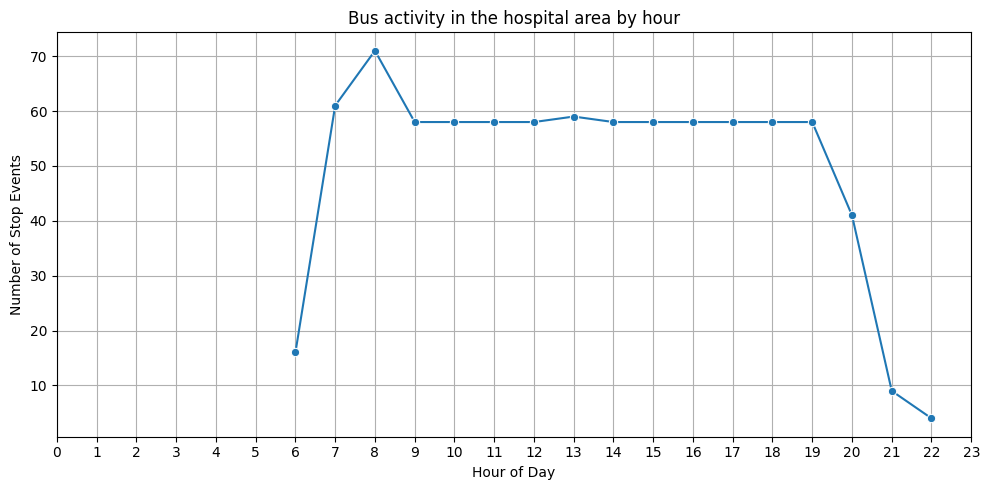

In [23]:
hospital = (46.055569,11.132340)
name = "hospital"
size = 500
bus_per_hour(hospital, size, name)

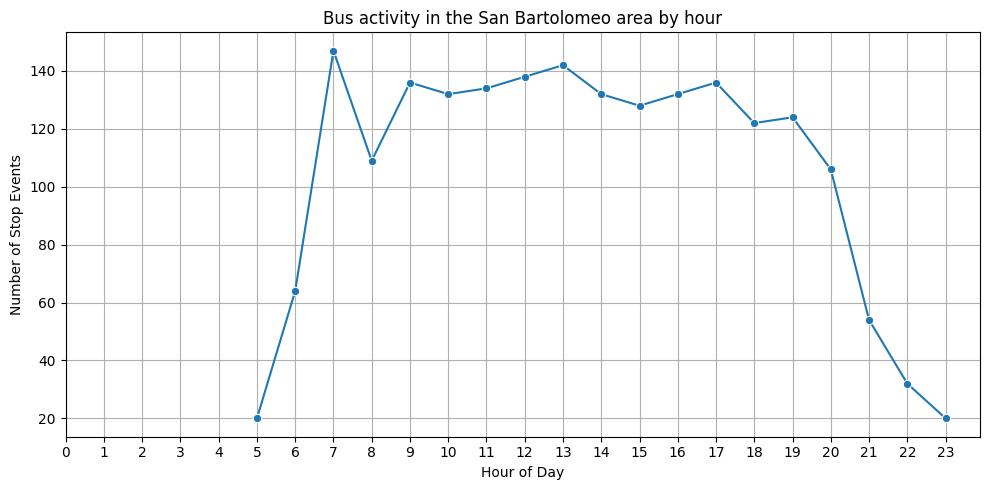

In [24]:
sanbapolis = (46.046395,11.132544)
name = "San Bartolomeo"
size = 500
bus_per_hour(sanbapolis, size, name)

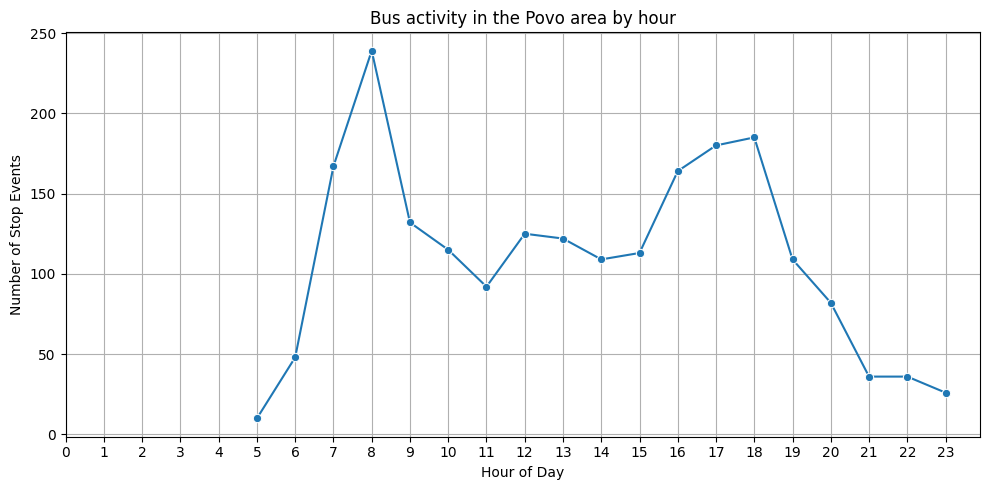

In [25]:
povo = (46.067527,11.150486)
name = "Povo"
size = 1000
bus_per_hour(povo, size, name)

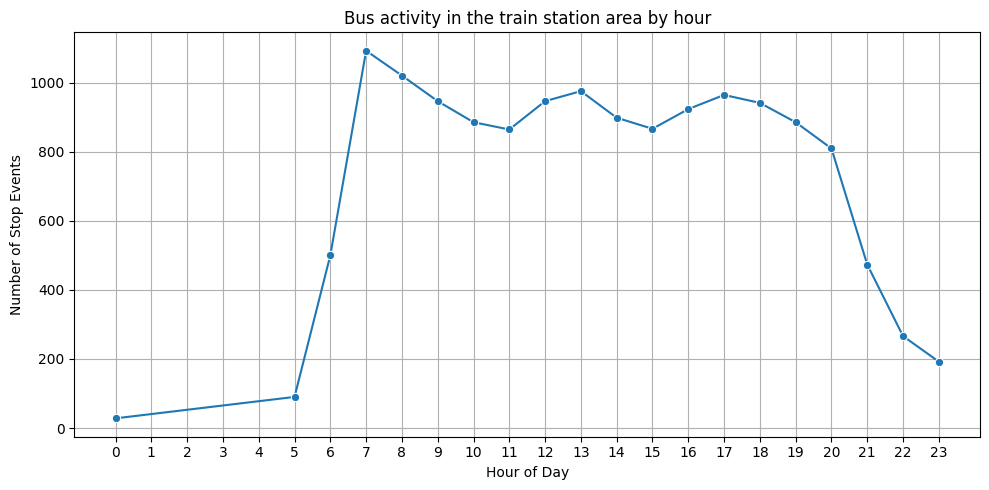

In [26]:
stazione = (46.074077,11.120666)
name = "train station"
size = 1000
bus_per_hour(stazione, size, name)

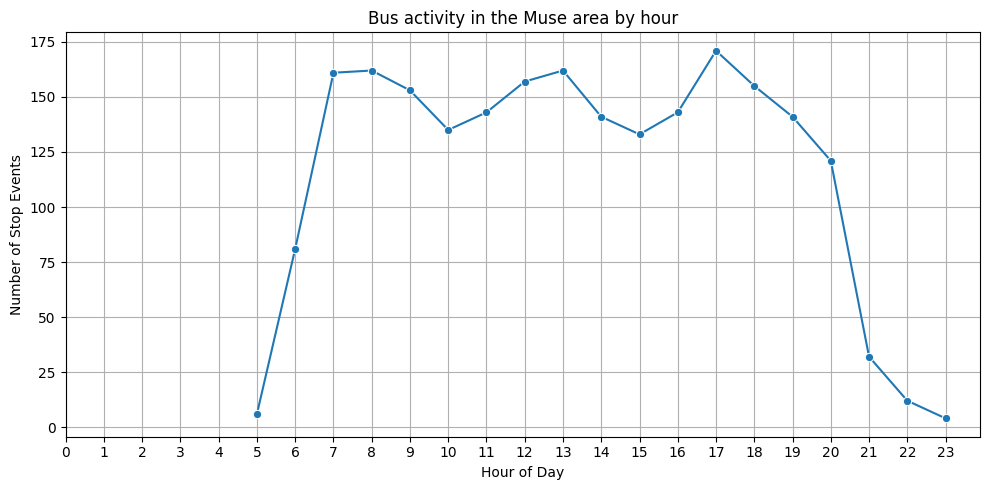

In [27]:
muse = (46.063259,11.113125)
name = "Muse"
size = 1000
bus_per_hour(muse, size, name)

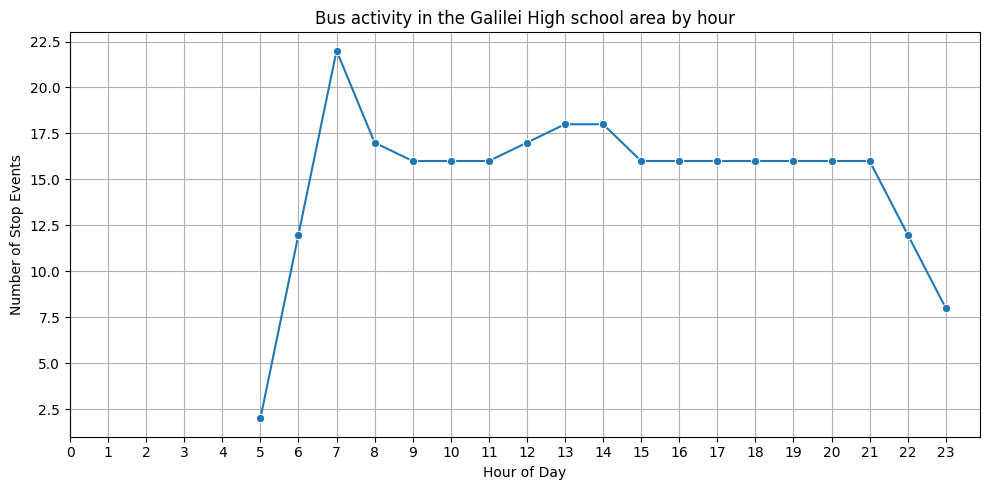

In [28]:
liceo_galilei= (46.06325, 11.13631)
name = "Galilei High school"
size = 500
bus_per_hour(liceo_galilei, size, name)